In [73]:
import math
import numpy as np
from scipy.optimize import minimize, minimize_scalar
import matplotlib.pyplot as plt

%matplotlib inline


def EB_fluxes(T_0,T_a,T_g,f,albedo,G,p,rho,U_L,z,z_0,dsoil,Ksoil):
    """ This function calculates the energy fluxes from the following quantities:
    
    Input: 
    T_0       : Surface temperature, which is optimized [K]
    f         : Relative humdity as fraction, e.g. 0.7 [-]
    albedo    : Snow albedo [-]
    G         : Shortwave radiation [W m^-2]
    p         : Air pressure [hPa]
    rho       : Air denisty [kg m^-3]
    z         : Measurement height [m]
    z_0       : Roughness length [m]
    
    """
    
    # Some constants
    c_p = 1004.0      # specific heat [J kg^-1 K^-1]
    kappa = 0.40      # Von Karman constant [-]
    sigma = 5.67e-8   # Stefan-Bolzmann constant
    
    # Bulk coefficients 
    Cs_t = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z_0) )
    Cs_q = np.power(kappa,2.0) / ( np.log(z/z_0) * np.log(z/z_0) )  
    
    # Correction factor for incoming longwave radiation
    eps_cs = 0.23 + 0.433 * np.power(100*(f*E_sat(T_a))/T_a,1.0/8.0)
    
    # Select the appropriate latent heat constant
    L = 2.83e6 # latent heat for sublimation

    # Calculate turbulent fluxes
    H_0 = rho * c_p  * Cs_t * U_L * (T_0-T_a)
    E_0 = rho * ((L*0.622)/p) * Cs_q * U_L * (E_sat(T_0)-f*E_sat(T_a))
    
    # Calculate radiation budget
    L_d = eps_cs * sigma * (T_a)**4
    L_u = sigma * (T_0)**4 
    Q_0 = (1-albedo)*G #+ L_d - L_u
    
    B = -Ksoil * ((T_0-T_g)/dsoil)

    return (Q_0, L_d, L_u, H_0, E_0, B)

def E_sat(T):
    """ Saturation water vapor equation """
    Ew = 6.112 * np.exp((17.67*(T-273.16)) / ((T-29.66)))
    return Ew


def optim_T0(x,T_a,T_g,f,albedo,G,p,rho,U_L,z,z0,dsoil,Ksoil):
    """ Optimization function for surface temperature:
    
    Input: 
    T_0       : Surface temperature, which is optimized [K]
    f         : Relative humdity as fraction, e.g. 0.7 [-]
    albedo    : Snow albedo [-]
    G         : Shortwave radiation [W m^-2]
    p         : Air pressure [hPa]
    rho       : Air denisty [kg m^-3]
    z         : Measurement height [m]
    z_0       : Roughness length [m]
    
    """
    
    Q_0, L_d, L_u, H_0, E_0, B = EB_fluxes(x,T_a,T_g,f,albedo,G,p,rho,U_L,z,z0,dsoil,Ksoil)
    
    # Get residual for optimization
    res = np.abs(Q_0+L_d-L_u-H_0-E_0+B)

    # return the residuals
    return res

In [23]:
def make_plot(data, x, z, levels, title, unit, xlab, zlab, cmap='RdBu_r', size=(18,5)):
    """ Useful function for plotting 2D-fields as contour plot"""
    
    # Create figure
    fig, ax = plt.subplots(1,1,figsize=size);
    cn0 = ax.contourf(x,z,data,10,origin='lower',levels=levels,cmap=cmap);
    
    # Add the colorbar and set ticks and labels
    cbar= fig.colorbar(cn0, ax=ax, orientation='vertical')
    cbar.set_label(label=unit, size=16)
    cbar.ax.tick_params(labelsize=14)
    
    # Add labels and modify ticks
    ax.set_xlabel(xlab, fontsize=14)
    ax.set_ylabel(zlab, fontsize=14)
    ax.set_title(title)
    
    # return the handler to the figure axes
    return ax

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
    
# --------------------------
# Auxiliary functions
# --------------------------
def saturation_water_vapor(T):
    """ Calculates the saturation water vapor pressure [Pa]"""
    return ( 6.122*np.exp( (17.67*(T-273.16))/(T-29.66) ) )

def hypsometric_eqn(p0, Tv, z):
    """Hypsometric equation to calculate the pressure at a certain height 
       when the surface pressure is given
       p0 :: surface pressure [hPa]
       Tv :: mean virtual temperature of atmosphere [K]
       z  :: height above ground [m]
    """
    return(p0/(np.exp((9.81*z)/(287.4*Tv) )))

def mixing_ratio(theta, p0, Tv, z):
    """ Calculates the mixing ratio from
        theta :: temperature [K]
        p0    :: surface pressure [hPa]
        Tv    :: mean virtual temperature of atmosphere [K]
        z     :: height [m]
    """
    return(622.97 * (saturation_water_vapor(theta)/(hypsometric_eqn(p0,Tv,z)-saturation_water_vapor(theta))))
           
    
def boundary_layer_evolution_moisture_gamma(u, K, theta, q, dx, dz, Nx, Nz, dt):
    """ Simple advection-diffusion equation.
    
    integration :: Integration time in seconds
    Nz          :: Number of grid points
    dt          :: time step in seconds
    K           :: turbulent diffusivity
    u           :: Speed of fluid
    """
    
    # Define index arrays 
    # Since this a 2D problem we need to define two index arrays.
    # The first set of index arrays is used for indexing in x-direction. This
    # is needed to calculate the derivatives in x-direction (advection)
    k   = np.arange(1,Nx-1) # center cell
    kr  = np.arange(2,Nx)   # cells to the right
    kl  = np.arange(0,Nx-2) # cells to the left
    
    # The second set of index arrays is used for indexing in z-direction. This
    # is needed to calculate the derivates in z-direction (turbulent diffusion)
    m   = np.arange(1,Nz-1) # center cell
    mu  = np.arange(2,Nz)   # cells above 
    md  = np.arange(0,Nz-2) # cells below

    # Make height grid
    height = np.array([np.arange(0,Nz*dz,dz),] * Nx).transpose()
    
    # Make lapse rate array
    Gamma = -0.01 * np.ones((Nz, Nx))
    
    # --------------------------
    # Initial temperature field
    # --------------------------
    # Neutral stratification with lapse rate of 0.01 K/m
    # Create a 1D-array with the vertical temperature distribution
    # Surface = 268 K, decreasing according to the dry-adiabative lapse rate 0.01 K/m
    lapse_rate = -0.01

    
    # --------------------------
    # Dimensionless parameters
    # --------------------------
    c = (u*dt)/dx
    d = (K*dt)/(dz**2)

    # --------------------------
    # Integrate the model
    # --------------------------
    # Set BC top (Neumann condition)
    # The last term accounts for the fixed gradient of 0.01
    theta[Nz-1, :] = theta[Nz-2, :]# - 0.005 * dz

    # Set top BC for moisture
    q[Nz-1, :] = q[Nz-2, :] 

    # Set BC right (Dirichlet condition)
    theta[:, Nx-1] = theta[:, Nx-2]

    # Set right BC for moisture
    q[:, Nx-1] = q[:, Nx-2]

    # We need to keep track of the old values for calculating the new derivatives.
    # That means, the temperature value a grid cell is calculated from its values 
    # plus the correction term calculated from the old values. This guarantees that
    # the gradients for the x an z direction are based on the same old values.
    old = theta
    old_q = q

    # First update grid cells in z-direction. Here, we loop over all x grid cells and
    # use the index arrays m, mu, md to calculate the gradients for the
    # turbulent diffusion (which only depends on z)
    for x in range(1,Nx-1):
        # Temperature diffusion + lapse rate 
        theta[m,x] = theta[m,x] + ((K*dt)/(dz**2))*(old[mu,x]+old[md,x]-2*old[m,x]) + Gamma[m,x]
        # Turbulent diffusion of moisture
        q[m,x] = q[m,x] + ((K*dt)/(dz**2))*(old_q[mu,x]+old_q[md,x]-2*old_q[m,x])
        # Calculate the warming rate [K/s] by covariance
        cov[m,x] = ((K)/(dz**2))*(old[mu,x]+old[md,x]-2*old[m,x])

    # Then update grid cells in x-direction. Here, we loop over all z grid cells and
    # use the index arrays k, kl, kr to calculate the gradients for the
    # advection (which only depends on x)
    for z in range(1,Nz-1):
        # temperature advection
        theta[z,k] = theta[z,k] - ((u*dt)/(dx))*(old[z,k]-old[z,kl])
        # moisture advection
        q[z,k] = q[z,k] - ((u*dt)/(dx))*(old_q[z,k]-old_q[z,kl])
        # Calculate the warming rate [K/s] by the horizontal advection 
        # Note: Here, we use a so-called upwind-scheme (backward discretization)
        adv[z,k] = - (u/dx)*(old[z,k]-old[z,kl])

    # Calculate new saturation mixing ratio
    qsat = mixing_ratio(theta, 1013, 270, height)

    # Then the relative humidity using qsat
    rH = np.minimum(q/qsat, 1)

    # Correct lapse rates where rH==100% (moist adiabatic lapse rate)
    Gamma[rH==1] = -0.006
        
    # Return results    
    return theta, q, qsat, rH, cov, adv, c, d, np.arange(0, Nx*dx, dx), np.arange(0, Nz*dz, dz)

In [59]:
def heat_equation_2D(T, dz, dt):
    """ Heat equation in 2D
    T :: temperature field in K
    dz:: grid spacing in meter
    dt:: time step in seconds
    """
    # Thermal conductivity
    K = 1.2e-6
    
    # Define the index array
    Nz = T.shape[0]
    k  = np.arange(1, Nz-1)
    kl = np.arange(0, Nz-2)
    ku = np.arange(2, Nz)
    
    # Store the old values
    Tnew = T
    
    # iterate over all x-nodes
    for x in range(T.shape[1]):
        
        # Set lower BC - Neumann condition
        T[Nz-1,:] = T[Nz-2,:]
        
        # Update temperatures
        Tnew[k,x] = T[k,x] + K * (dt/dz**2) * (T[ku,x]-2*T[k,x]+T[kl,x])
        
    return Tnew

In [78]:
#-----------------------------
# Grid information
#-----------------------------
dx = 500.0   # in meter
dz = 5.0     # in meter
dsoil = 0.5  # in meter
dt = 60.   # time step in seconds
Nx = 20    # number of grid nodes in x direction
Nz = 20    # number of grid nodes in z direction
Nd = 20    # number of grid nodes in -z direction (soil) 

# Integration time
integration =12*3600. # integration period in seconds

# Make height grid for the atmosphere
height = np.array([np.arange(0,Nz*dz,dz),] * Nx).transpose()

#-----------------------------
# Atmospheric conditions
#-----------------------------
u = 5.0 # Wind velocity in meters per second
K = 0.2 # turbulent diffusivity m^2/s
albedo = 0.3 # Albedo
G0 = 400.     # Incoming shorwave radiation in Watt per square meter
rho = 1.2    # air density kg per m^3
z = 2.0      # measurement height in meter
z0 = 1e-3    # roughness length in meter
p0 = 1013    # Surface pressure hPa
T0_init = 268 # Initial surface temperature in K

#-----------------------------
# Initialize Temperature field
#-----------------------------
# Neutral stratification with lapse rate of 0.01 K/m
# Create a 1D-array with the vertical temperature distribution
# Surface = 268 K, decreasing according to the dry-adiabative lapse rate 0.01 K/m
lapse_rate = -0.01
theta_vec = np.array([T0_init + lapse_rate * (dz * z) for z in range(Nz)])
theta = np.array([theta_vec,] * Nx).transpose() 

#-----------------------------
# Initialize moisture field
#-----------------------------
# Init saturation mixing ratio array
Tatm = 270   # Mean boundary layer temperature in K
qsat = mixing_ratio(theta, p0, Tatm, height)
rH0 = 0.7 # relative humidity at the surface
rH1 = 0.2 # relative humidity at the top

# Thermal conductivity
Ksoil = 1.2e-6

# Use qsat to derive mixing ratio at each grid node assuming decreasing RH
q = (qsat.T * np.linspace(rH0, rH1, Nz)).T

#-----------------------------
# Initialize cov and adv field
#-----------------------------
cov = np.zeros((Nz,Nx))
adv = np.zeros((Nz,Nx))

#-----------------------------
# Initialize soil temperature
#-----------------------------
Tsoil = T0_init * np.ones((Nd,Nx))

#-----------------------------
# Do the simulation
#-----------------------------

for t in range(int(integration/dt)):
    
    # Daily cycle in shortwave radiation
    G = np.maximum(0, G0 * np.sin((2*math.pi*t*dt)/86400))
    
    # Update saturation water vapor
    qsat = mixing_ratio(theta, p0, Tatm, height)
    
    #----------------------------------------
    # Solve for the new surface temperature
    #----------------------------------------
    # Iterate over x-nodes
    for idx in range(Nx):
        
        # Optimize surface temperature
        res = minimize(optim_T0, x0=280, args=(theta[1,idx],Tsoil[1,idx], q[1,idx]/qsat[1,idx], \
                albedo, G, p0, rho, u, z, z0, dsoil, Ksoil), method='L-BFGS-B', options={'eps':1e-8})
        
        # update temperature field 
        theta[0,idx] = res.x
        
        # update soil temperature field 
        Tsoil[0,idx] = res.x
        
    #----------------------------------------      
    # Solve the soil heat equation
    #----------------------------------------
    Tsoil = heat_equation_2D(Tsoil, dsoil, dt)
    
    #----------------------------------------      
    # Solve the advection-diffusion equation
    #----------------------------------------
    theta, q, qsat, rH, cov, adv, c, d, x, height = \
    boundary_layer_evolution_moisture_gamma(u, K, theta, q, cov, adv, dx, dz, Nx, Nz, dt)
    


/var/folders/1_/95j8qvxd7x1b2m_6v4rz8p5m0000gn/T/ipykernel_36302/630821201.py:54: RuntimeWarning: overflow encountered in exp
  Ew = 6.112 * np.exp((17.67*(T-273.16)) / ((T-29.66)))


<AxesSubplot:title={'center':'Temperature'}, xlabel='Distance [km]', ylabel='Height'>

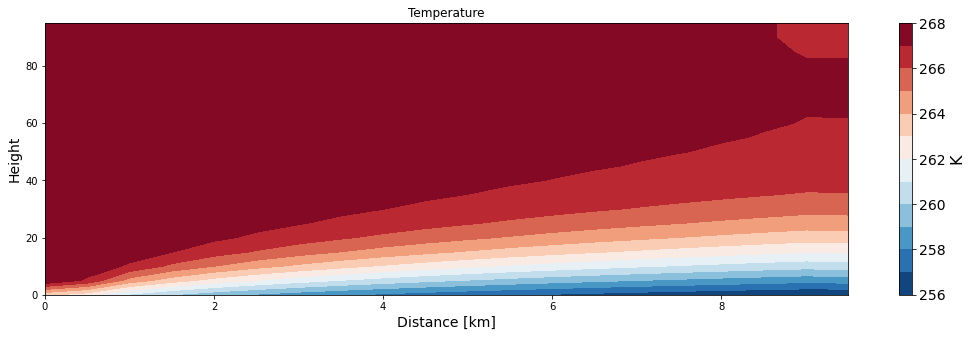

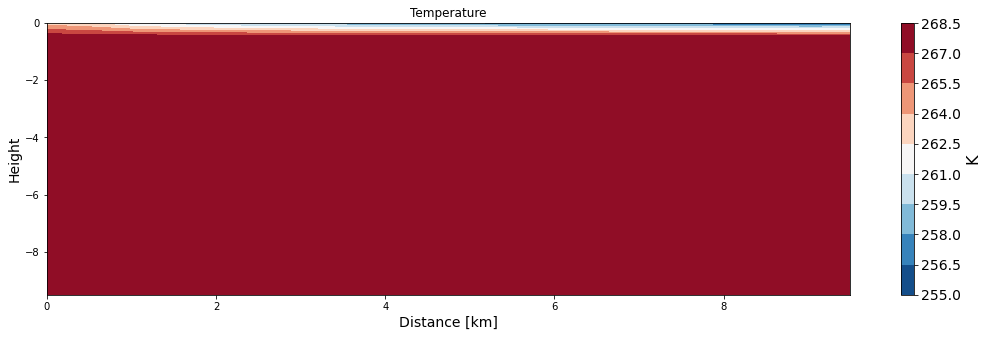

In [79]:
make_plot(theta, x=x/1000, z=height, levels=11, title='Temperature', \
          unit='K', xlab='Distance [km]', zlab='Height')

make_plot(Tsoil, x=x/1000, z=np.arange(0,-Nd*dsoil,-dsoil), levels=11, title='Temperature', \
          unit='K', xlab='Distance [km]', zlab='Height')